<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/2_Introduction_to_kite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transport in graphene: using Quantum Kite




In this notebook, we will keep exploring graphene but for transport calculations we will begin using *Quantum Kite*.
*Kite* is written in C++ but has a python interface that uses the same syntax of pybinding.
The interface generates an h5 input file for Kite, which is also used to write the output. *Kite-tools* post-processes this file and generates the data files. In this notebook, we introduce *Kite* in the context of quantum properties of 2D materials.

If you are familiar with python you can install pybinding and kite on your python enviroment with pip. Otherwise, you can use our notebooks in google colab.


The first two lines install pybinding, kite and their dependencies that are not included in google colab.
Now we are removing the output as we already know what it is installing


In [1]:
%%capture --no-display
!pip install h5py==3.11.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite==0.0.4


Now we import the libraries

In [2]:
import numpy as np
from math import sqrt, pi
import pybinding as pb
import kite
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# seaborn setting
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})


**IMPORTANT:** Before we start with Quantum Kite, let state that we had to adapt kite to run in the colab notebooks and be involked directly from the python script. That means we cannot write the h5 file several times in a given script here, otherwise it crashes. If there is any strange message from colab, disconnect, delete the runtime and start running the notebook again. Here we use the same script to calculate several quantities, to avoid any complication from Kite and colab.


---



---






Now let us go back to a graphene lattice and use it. We already know how to import and use the graphene lattice and the rest of instructions are related to definitions necessary to run KITE

One needs to define the size of the lattice that will be calculated (like a model in pybinding) in units of the unit cell and to speedup the calculation, it can be devided in sections that run in parallel. The script has comments with the explanation. We can also have open or periodic boundary conditions and perform different types of calculation. We start with the density of states. When it is called, it is necessary to define a number of quantities. For that, it is good to refer to KITE's paper, that explain them to you.

First we define the lattice exactly like in *pybinding* and we can use all predefined lattices and others that we will provide in our notebooks. We than need to define in how many pieaces we will cut out system based on the number of cores the computer has. Nowadays, most computers are at least quadricore so we can easily define `nx` and `ny` as 2. `ly` and `ly` are the number of unit cells in each of the lattice vector directions, remembering that now we are working in real space the whole time. Finally, we decide the type of boundary condition. Let us focus only on periodic and open.
With these informations, we define the configuration that also includes the precision of the calculation and defines if there are complex variables or not (for memory purpose). Let us see how it works


1.   Load lattice

In [3]:
from pybinding.repository import graphene
lattice = graphene.monolayer()



1.   Define the number of decomposition parts `[nx,ny]` in each direction of matrix.




In [4]:
nx = ny = 2


3.   Define the number of unit cells in each direction.

In [5]:
lx = ly = 256

4.   Define the boundary conditions [mode,mode, ... ] with modes:

*   "periodic"
*   "open"
*   "twisted" -- this option needs the extra argument angles=[phi_1,..,phi_DIM] where phi_i \in [0, 2*M_PI]
*   "random"


In [6]:
mode = "periodic"

make config object which caries info about
     -

*   the number of decomposition parts `[nx, ny]`,
*   lengths of structure `[lx, ly]`
*   boundary conditions `[mode,mode, ... ] `


     

In [7]:
configuration = kite.Configuration(
        divisions=[nx, ny],
        length=[lx, ly],
        boundaries=[mode, mode],
        is_complex=False,
        precision=1
)

Now it is time to specify the different calculations. We first use a instruction where we pass the configuration to our calculations.
After that instruction, we are ready to perform the different possible calculations. The most basic one is the density of states. We need to define the number of energy points where we calculate the DOS, the number of moments in the Chebyshev expansion, random vectors (these are related with the method used in Kite. Refer to [Kite website](https://quantum-kite.com) or article for more information), and disorder realizations, as Kite is a powerful tool to study disorder in solids.

In [8]:


    # specify calculation type
calculation = kite.Calculation(configuration)
calculation.dos(
        num_points=4000,
        num_moments=512,
        num_random=10,
        num_disorder=1
)


We can also calculate the DC conductivity using Kubo´s formula where we also define the direction in the conductivity tensor and the temperature. This calculation is made in the whole spectrum and depends on the square of the number of moments in the expansion while the calculation of DOS depends linearly on the number of moments. Be aware of the time.  There is another way to perform calculations of the longitudinal conductivity (linearly with the number of moments) in a specific energy window but this will be discussed elsewhere.

In [9]:
calculation.conductivity_dc(
    num_points=2000,
    num_moments=256,
    num_random=10,
    direction='xx',
    temperature=0.05
)

After defining the calculations, one needs to define the output h5 file where this information and the results will be stored and write the file using `kite.config_system.`
Kite is better executed from a prompt using `>./kitex file.h5`. However, for the colab notebook we are using an adapted version where it can be involked directly from the python script. kitetools, the post-processing tools that extract the information from the h5 file, calculates the different quantities and write .dat files with the results, can also be involked from here but it is normally involked from the prompt with `>./kite-tools file.h5`. It also has several options and extra features for the different types of calculations. Please refer to Kite's webpage for information.

In [10]:


    # configure the *.h5 file
output_file = "graphene_lattice-output.h5"
kite.config_system(lattice, configuration, calculation, filename=output_file)





##############################################################################
#                        KITE | Release  1.1                                 #
#                        Kite home: quantum-kite.com                         #
#                                                                            #
#                        Copyright 2022, KITE                                #
##############################################################################

##############################################################################

SCALING:


Automatic scaling is being done. If unexpected results are produced, consider 
selecting the bounds manually. 
Estimate of the spectrum bounds with a safety factor is: 
(-8.52, 8.48 eV)


##############################################################################

BOUNDARY CONDITIONS:


Boundary conditions along the lattice vectors are set to:
 
a1: Periodic     a2: Periodic 


##################################################

Here is the executing instruction to execute kite inside a python script (beta version)

In [11]:
# executing kite inside a python script
kite.execute.kitex(output_file);

<HDF5 dataset "IS_COMPLEX": shape (), type "<u4">


postprocessing the output file. Check kite documentation to know the names of postprocessed files

In [12]:

kite.execute.kitetools(output_file);


We can now plot the density of states



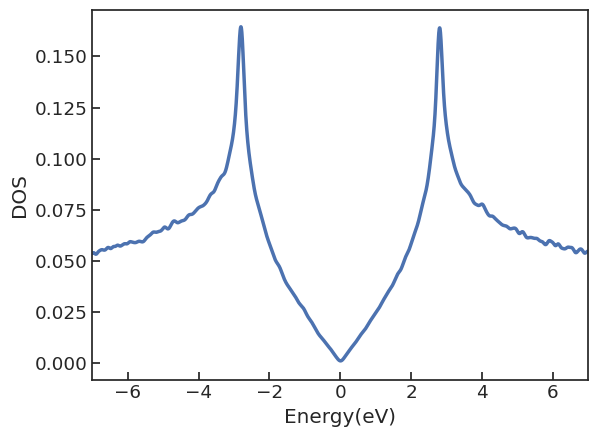

In [13]:
dos=np.loadtxt("dos.dat",dtype=float)
plt.plot(dos[:,0],dos[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("DOS")
plt.xlim(-7,7)
plt.show()

the DC conductivity

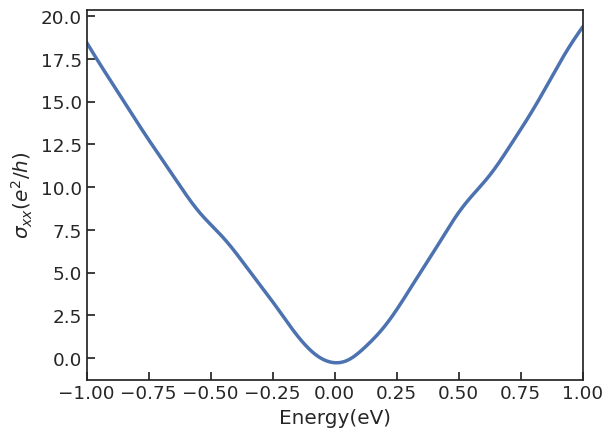

In [14]:
cond=np.loadtxt("condDC.dat",dtype=float)
plt.plot(cond[:,0],cond[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("$\sigma_{xx}(e ^2/h)$")
plt.xlim(-1.,1.)
plt.show()

By default, kite-tools calculate the conductivity for Fermi energies in the range [-1 eV, 1 eV]. To change these limits, you can run kite-tools with a few options. You can also change the temperature, integration points etc.  Refer to the [kite-tools API](https://quantum-kite.com/api/kite-tools/#advanced-usage) for more details.



In [21]:
kite.execute.kitetools("graphene_lattice-output.h5 --CondDC -F -6 6 4000");

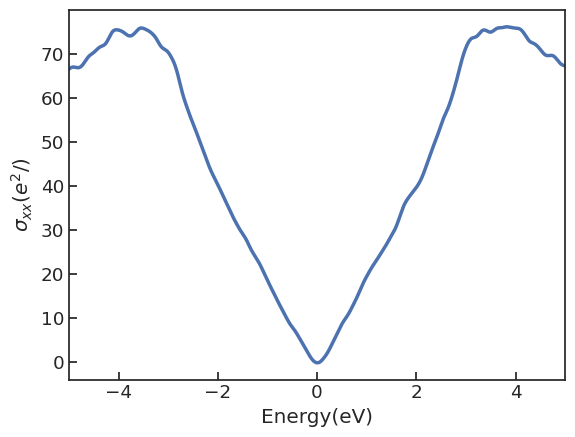

In [23]:
cond=np.loadtxt("condDC.dat",dtype=float)
plt.plot(cond[:,0],cond[:,1])

plt.xlabel("Energy(eV)")
plt.ylabel("$\sigma_{xx}(e ^2/)$")
plt.xlim(-5,5)

plt.show()